In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import seaborn as sns
import cobra
import scipy.stats as st
import scipy
sys.path.append('../../code/')
import leakage

In [2]:
folder = Path('/Users/ssulheim/Library/CloudStorage/OneDrive-UniversitédeLausanne/UNIL/leakage/experimental work/KEIO_KO_growth_test_and_exometabolome_screening_240122/exometabolome')

In [120]:
fn = folder / 'SM_AA_AC_TCA_Glycolisis_quantification_Results.xlsx'
mapping_fn = folder.parent.parent /'sintef_sept_23/exometabolome'/'met_to_bigg.csv'
od_fn = folder / '..' / 'plan_240122.xlsx'
id_mapping_fn = folder / 'id_mapping.csv'

## Read mapping

In [124]:
mapping_dict = pd.read_csv(mapping_fn, index_col = 0).to_dict()['BiGG ID']

In [125]:
mapping_dict

{'SEBACOYL-L-CARNITINE (C10-DC)': nan,
 'DEOXYCARNITINE (DEOXY-C0)': 'gbbtn',
 'GLUTARYLCARNITINE (C5-DC)': nan,
 'ALPHA-AMINOBUTYRATE': nan,
 'CREATINE': 'crn',
 'ALPHA-AMINOADIPATE': nan,
 'CIS-ACONITATE': 'acon_C',
 'CITRATE': 'cit',
 'HEXOSES including Glucose and Fructose': 'fru',
 'GLUTARATE': nan,
 'ISOCITRATE': 'icit',
 'LACTATE': 'lac__L',
 'MALATE': 'mal__L',
 'NAD': 'nad',
 'SUCCINATE': 'succ',
 'TRANS-ACONITATE': 'acon_T',
 'ASPARAGINE': 'asn__L',
 'ASPARTATE': 'asp__L',
 'BETA-ALANINE': 'ala_B',
 'GAMMA-AMINOBUTYRATE': '4abut',
 'GLUTAMATE': 'glu__L',
 'GLUTAMINE': 'gln__L',
 'GLYCINE': 'gly',
 'ISOLEUCINE': 'ile__L',
 'LEUCINE': 'leu__L',
 'LYSINE': 'lys__L',
 'METHIONINE': 'met__L',
 'PHENYLALANINE': 'phe__L',
 'PIPECOLIC ACID': nan,
 'PROLINE': 'pro__L',
 'SERINE': 'ser__L',
 'TYROSINE': 'tyr__L',
 'VALINE': 'val__L',
 'ALANINE': 'ala__L',
 'PYRUVATE': 'pyr',
 'CITRULLINE': 'citr__L',
 'HISTIDINE': 'his__L',
 'MALONYLCARNITINE (C3:DC)': nan,
 'FRUCTOSE-6-PHOSPHATE': 'f6

In [126]:
id_mapping = pd.read_csv(id_mapping_fn, index_col=0).to_dict()['OD_ID']

In [127]:
id_mapping

{'SR_MPTA_020204_11A-2_WT_22': '11A-2: WT',
 'SR_MPTA_020204_11B-2_WT_23': '11B-2: WT',
 'SR_MPTA_020204_11C-2_WT_24': '11C-2: WT',
 'SR_MPTA_020204_12A-1_pool_A_25': '12A-1: pool',
 'SR_MPTA_020204_12B-1_pool_B_26': '12B-1: pool',
 'SR_MPTA_020204_12C-1_pool_C_27': '12C-1: pool',
 'SR_MPTA_020204_1A-2_aceE_1': '1A-2: aceE',
 'SR_MPTA_020204_1B-2_aceE_2': '1B-2: aceE',
 'SR_MPTA_020204_1C-2_aceE_3': '1C-2: aceE',
 'SR_MPTA_020204_2A-2_cyoD_4': '2A-2: cyoD',
 'SR_MPTA_020204_2B-2_cyoD_5': '2B-2: cyoD',
 'SR_MPTA_020204_2C-2_cyoD_6': '2C-2: cyoD',
 'SR_MPTA_020204_3A-2_lacA_7': '3A-2: lacA',
 'SR_MPTA_020204_3B-2_lacA_8': '3B-2: lacA',
 'SR_MPTA_020204_3C-2_lacA_9': '3C-2: lacA',
 'SR_MPTA_020204_4A-2_nuoA_10': '4A-2: nuoA',
 'SR_MPTA_020204_4B-2_nuoA_11': '4B-2: nuoA',
 'SR_MPTA_020204_4C-2_nuoA_12': '4C-2: nuoA',
 'SR_MPTA_020204_5A-2_pgi_13': '5A-2: pgi',
 'SR_MPTA_020204_5B-2_pgi_14': '5B-2: pgi',
 'SR_MPTA_020204_5C-2_pgi_15': '5C-2: pgi',
 'SR_MPTA_020204_6A-2_rpe_16': '6A-2: rpe',

## Read OD and convert to biomass

In [ ]:
od_samples_df = pd.read_excel(od_fn, sheet_name='Ex. samples', skiprows= 3, nrows=75, header=0)
od_samples_df.drop(index = 0, inplace=True)
od_samples_df['Replicate'] = od_samples_df['Sample ID2'].str[-1]

In [116]:
od_dict = od_samples_df.set_index('Sample ID')['OD'].to_dict()
strain_dict = od_samples_df.set_index('Sample ID')['Strain'].to_dict()
rep_dict = od_samples_df.set_index('Sample ID')['Replicate'].to_dict()

In [43]:
# rel_to_info = {
#     'REL01': {'M': 'M1', 'CS': 'Galactose'},
#     'REL02': {'M': 'M2', 'CS': 'Galactose'},
#     'REL03': {'M': 'M3', 'CS': 'Galactose'},
#     'REL04': {'M': 'M5', 'CS': 'L-malate'},
#     'REL05': {'M': 'M6', 'CS': 'L-malate'},
#     'REL06': {'M': 'M7', 'CS': 'L-malate'},
#     'REL07': {'M': 'M9', 'CS': 'L-alanine'},
#     'REL08': {'M': 'M10', 'CS': 'L-alanine'},
#     'REL09': {'M': 'M11', 'CS': 'L-alanine'}
#     }
# M_to_rel = {dic['M']:rel for rel, dic in rel_to_info.items()}


In [34]:
# od_df.rename(columns={'Unnamed: 0': 'Timestamp', 'Unnamed: 1': 'Time', 'Unnamed: 2': 'Hours'}, inplace=True)

## Read exometabolome

In [ ]:
df = pd.read_excel(fn, nrows=29)


# Remove columns with no detected metabolites

In [194]:
df.columns = [x.rstrip(' ') for x in df.columns]
data_columns = df.columns[1:]
df[data_columns] = df[data_columns].apply(pd.to_numeric, errors='coerce')

In [196]:
df

,Sample_ID,PHENYLALANINE,LEUCINE,GAMMA-AMINOBUTYRATE,PROLINE,VALINE,BETA-ALANINE,ALANINE,ALPHA-AMINOADIPATE,GLYCINE,...,MALONYLCARNITINE (C3:DC),LACTATE,FRUCTOSE-6-PHOSPHATE,MALATE,GLUCOSE-6-PHOSPHATE,CIS-ACONITATE,CITRATE,ISOCITRATE,TRANS-ACONITATE,OD_ID
1,SR_MPTA_020204_6B-2_rpe_17,NaN,4.475191,2.372766,NaN,NaN,0.209379,2.991016,NaN,NaN,...,0.268126,10.839721,16.355687,0.597649,NaN,0.228815,28.952158,0.401419,0.018529,NaN
2,SR_MPTA_020204_1C-2_aceE_3,NaN,2.158598,0.317478,NaN,1.004614,0.040708,1.182035,NaN,NaN,...,0.181086,4861.602845,11.816233,0.139965,NaN,0.206426,26.158509,0.258453,0.013116,NaN
3,SR_MPTA_020204_3B-2_lacA_8,NaN,4.501261,1.778552,NaN,NaN,0.138165,4.270851,0.032604,NaN,...,0.787222,21.707870,14.303282,0.572703,NaN,0.122040,17.519020,0.136286,0.016634,NaN
4,SR_MPTA_020204_1A-2_aceE_1,NaN,1.972138,0.216765,NaN,0.600270,0.050380,0.806517,NaN,NaN,...,0.240869,8064.894166,11.940145,NaN,NaN,0.165473,17.582886,0.135999,0.014170,NaN
5,SR_MPTA_020204_11A-2_WT_22,NaN,2.991655,1.076198,NaN,NaN,0.127876,1.151225,0.075641,NaN,...,0.682804,2.506314,8.912813,0.350877,NaN,0.129831,14.801017,0.073107,0.011540,NaN
6,SR_MPTA_020204_12B-1_pool_B_26,NaN,NaN,0.071646,NaN,NaN,NaN,NaN,0.013436,NaN,...,0.082426,NaN,3.000158,NaN,NaN,NaN,12.045165,NaN,NaN,NaN
7,SR_MPTA_020204_3C-2_lacA_9,NaN,4.576851,1.392341,NaN,NaN,0.137117,4.444514,0.038752,NaN,...,0.469943,12.156362,7.557362,0.624442,NaN,0.095567,11.089794,NaN,0.010381,NaN
8,SR_MPTA_020204_11B-2_WT_23,NaN,3.013691,1.657567,NaN,NaN,0.132826,1.285605,0.075804,NaN,...,0.956324,3.057363,6.312031,0.405368,NaN,0.107486,11.165142,NaN,0.015071,NaN
9,SR_MPTA_020204_11C-2_WT_24,NaN,3.389586,1.585592,NaN,NaN,0.130245,1.357413,0.067010,NaN,...,0.739392,1.219408,7.981973,0.405993,NaN,0.121219,11.572504,0.022688,0.015475,NaN
10,SR_MPTA_020204_3A-2_lacA_7,NaN,3.825709,1.835226,NaN,NaN,0.152295,0.863727,0.040664,NaN,...,0.622336,7.212336,8.365247,0.363577,NaN,0.125593,10.537609,NaN,0.017728,NaN


In [197]:
df = df.loc[:, ~df.isna().all()]
data_columns = df.columns[1:]


In [198]:
data_columns

Index(['PHENYLALANINE', 'LEUCINE', 'GAMMA-AMINOBUTYRATE', 'PROLINE', 'VALINE',
       'BETA-ALANINE', 'ALANINE', 'ALPHA-AMINOADIPATE', 'GLYCINE', 'GLUTAMINE',
       'GLUTAMATE', 'SERINE', 'ASPARAGINE', 'CITRULLINE', 'ASPARTATE',
       'HISTIDINE', 'DEOXYCARNITINE (DEOXY-C0)', 'GLUTARYLCARNITINE (C5-DC)',
       'MALONYLCARNITINE (C3:DC)', 'LACTATE', 'FRUCTOSE-6-PHOSPHATE', 'MALATE',
       'GLUCOSE-6-PHOSPHATE', 'CIS-ACONITATE', 'CITRATE', 'ISOCITRATE',
       'TRANS-ACONITATE'],
      dtype='object')

In [199]:
# data_columns = ['SEBACOYL-L-CARNITINE (C10-DC) ', 'DEOXYCARNITINE (DEOXY-C0) ',
#        'GLUTARYLCARNITINE (C5-DC) ', 'PHENYLALANINE ', 'LEUCINE ',
#        'ISOLEUCINE ', 'METHIONINE ', 'GAMMA-AMINOBUTYRATE ', 'PROLINE ',
#        'TYROSINE ', 'VALINE ', 'PIPECOLIC ACID ', 'ALPHA-AMINOBUTYRATE ',
#        'BETA-ALANINE ', 'ALANINE ', 'CREATINE ', 'ALPHA-AMINOADIPATE ',
#        'GLYCINE ', 'GLUTAMINE ', 'GLUTAMATE ', 'SERINE ', 'ASPARAGINE ',
#        'ASPARTATE ', 'LYSINE ', 'PYRUVATE ', 'LACTATE ',
#        'HEXOSES including Glucose and Fructose ', 'NAD ', 'GLUTARATE ',
#        'SUCCINATE ', 'MALATE ', 'CIS-ACONITATE ', 'CITRATE ', 'ISOCITRATE ',
#        'TRANS-ACONITATE ']
control_samples = ['SR_MPTA_020204_12A-1_pool_A_25', 'SR_MPTA_020204_12B-1_pool_B_26', 'SR_MPTA_020204_12C-1_pool_C_27']

In [200]:
control_idx = df['Sample_ID'].isin(control_samples)

## Outliers in medium measurements

In [201]:
# df.loc[39, ['SUCCINATE', 'MALATE']] = 'ND'
# df['MALATE'] = 'ND'
# # Also errors with malate
# Galactose-T12_M1_4, Galactose-T8_M3, Galactose-T14_M2, Galactose-T14_M3, Galactose-T6_M2, Galactose-T12_M2, L-alanine-T18_M11, L-alanine-T18_M9

## Read medium values

In [202]:
control_df = df.loc[control_idx,:].copy()
# control_df.fillna(0, inplace = True)
# control_df.replace('ND', np.nan, inplace=True)



In [266]:
medium_value = control_df[data_columns].mean()
medium_value.fillna(0, inplace=True)

In [270]:
medium_value

PHENYLALANINE                0.000000
LEUCINE                      0.000000
GAMMA-AMINOBUTYRATE          0.066753
PROLINE                      0.000000
VALINE                       0.000000
BETA-ALANINE                 0.000000
ALANINE                      0.000000
ALPHA-AMINOADIPATE           0.013436
GLYCINE                      0.000000
GLUTAMINE                    0.000000
GLUTAMATE                    2.554003
SERINE                       0.000000
ASPARAGINE                   0.000000
CITRULLINE                   0.000000
ASPARTATE                    0.070470
HISTIDINE                    0.000000
DEOXYCARNITINE (DEOXY-C0)    0.000000
GLUTARYLCARNITINE (C5-DC)    0.005729
MALONYLCARNITINE (C3:DC)     0.059910
LACTATE                      0.000000
FRUCTOSE-6-PHOSPHATE         2.786780
MALATE                       0.000000
GLUCOSE-6-PHOSPHATE          0.000000
CIS-ACONITATE                0.000000
CITRATE                      7.663036
ISOCITRATE                   0.000000
TRANS-ACONIT

In [272]:
df_diff = df[data_columns]-medium_value
df_diff['Sample_ID'] = df['Sample_ID']

In [294]:
# control_df = control_df[['Class 1']+data_columns]

In [295]:
dfl = df_diff.loc[~control_idx,:].melt(id_vars=['Sample_ID'], value_vars=data_columns, value_name='Concentration', var_name = 'Metabolite')

In [296]:
dfl

,Sample_ID,Metabolite,Concentration
0,SR_MPTA_020204_6B-2_rpe_17,PHENYLALANINE,NaN
1,SR_MPTA_020204_1C-2_aceE_3,PHENYLALANINE,NaN
2,SR_MPTA_020204_3B-2_lacA_8,PHENYLALANINE,NaN
3,SR_MPTA_020204_1A-2_aceE_1,PHENYLALANINE,NaN
4,SR_MPTA_020204_11A-2_WT_22,PHENYLALANINE,NaN
...,...,...,...
643,SR_MPTA_020204_4B-2_nuoA_11,TRANS-ACONITATE,0.014089
644,SR_MPTA_020204_4A-2_nuoA_10,TRANS-ACONITATE,0.015284
645,SR_MPTA_020204_8A-2_sucB_19,TRANS-ACONITATE,0.099636
646,SR_MPTA_020204_5C-2_pgi_15,TRANS-ACONITATE,NaN


In [297]:
# dfl.replace('ND', np.nan, inplace=True)

In [298]:
dfl['OD ID'] = dfl['Sample_ID'].map(id_mapping)
dfl['Strain'] = dfl['OD ID'].map(strain_dict)
dfl['OD'] = dfl['OD ID'].map(od_dict)
dfl['Replicate'] = dfl['OD ID'].map(rep_dict)

In [299]:
# dfl['Timepoint'] = dfl['Class 2'].str.strip('T').astype(int)

In [300]:
# dfl.loc[dfl.Timepoint != 4,:]

In [301]:
# dfl.sort_values('Strain')['Strain'].unique()
order = ['WT', 'lacA', 'aceE', 'cyoD', 'nuoA', 'pgi', 'rpe', 'sucB']

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


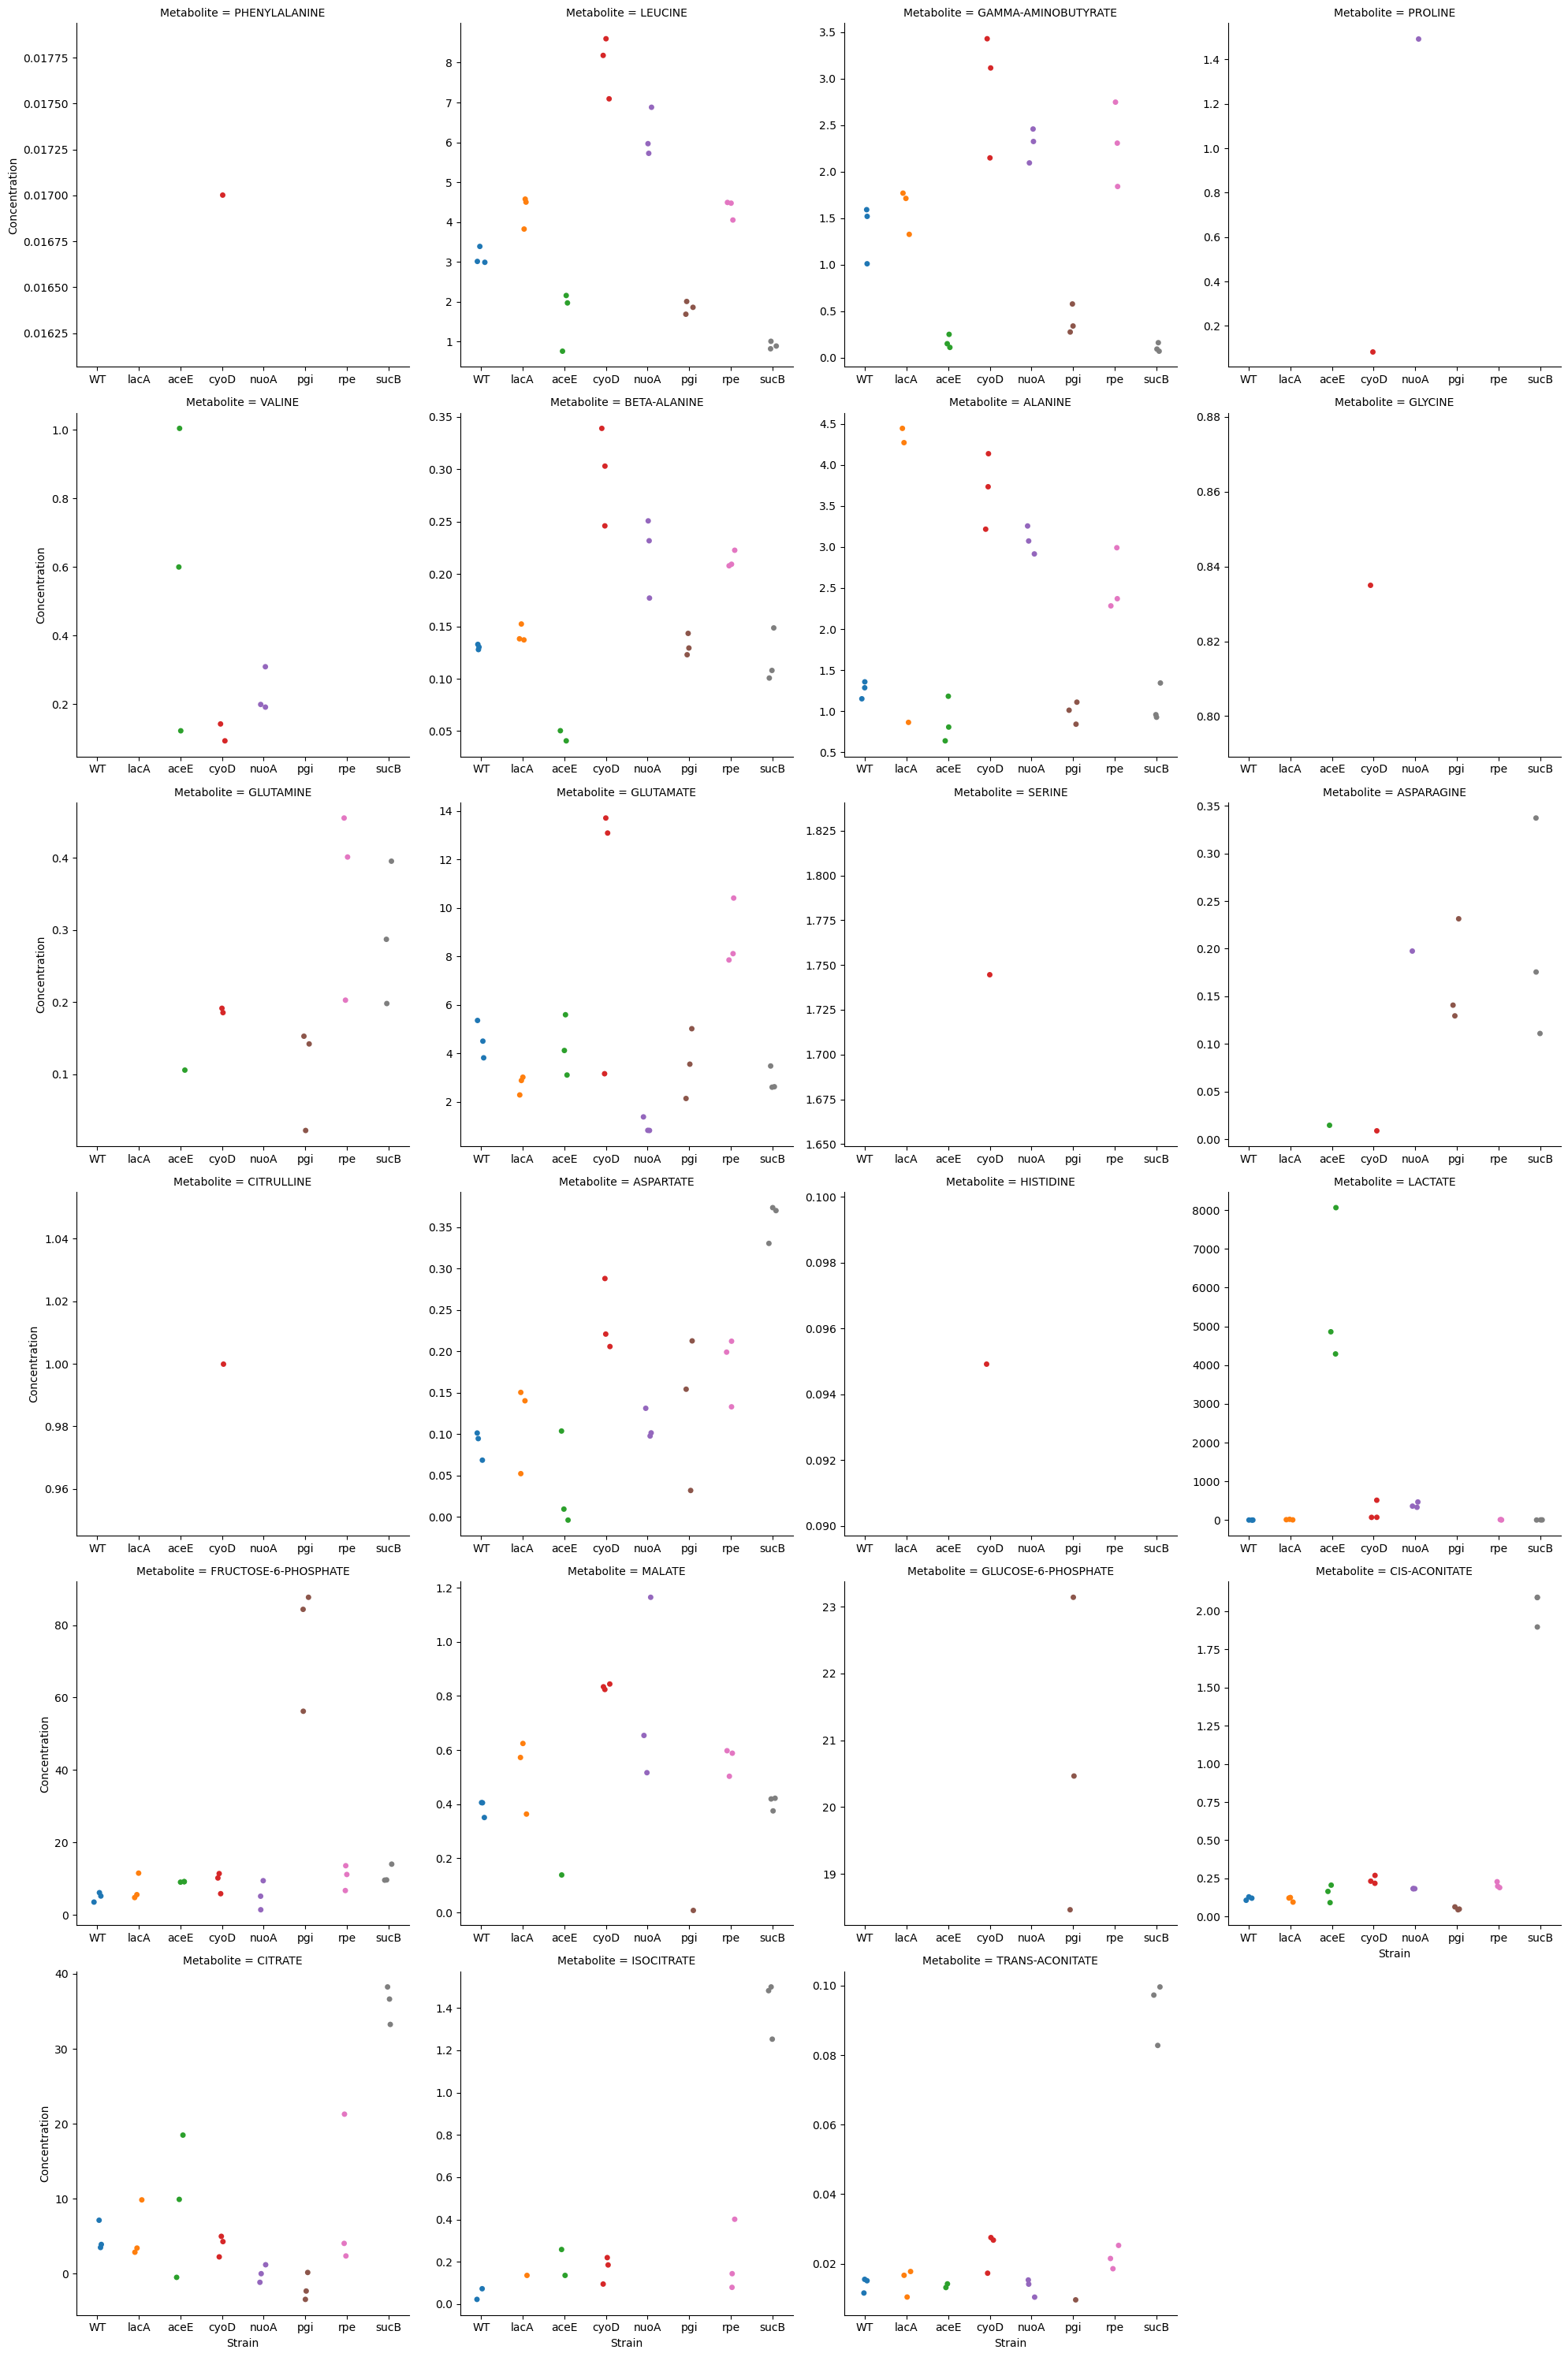

In [318]:

sns.catplot(data = dfl, x = 'Strain', y = 'Concentration', col = 'Metabolite', col_wrap=4, sharey=False, sharex= False, order = order)
# ax.map_dataframe(sns.lineplot, 'Timepoint', 'Concentration', hue = 'Class 1', style = 'M')
plt.show()

In [4]:
model_ez = cobra.io.read_sbml_model('../../models/e_coli/momentiJO1366.xml')
model_ez.id = 'moment-iJO1366'
model_ez.solver = 'gurobi'
model_ez.reactions.EX_glc__D_e.lower_bound = 0
model_ez.reactions.EX_gal_e.lower_bound = -10

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-19


In [330]:
# model = cobra.io.read_sbml_model('../../models/e_coli/iJO1366.xml')
# model.solver = 'gurobi'
# model.reactions.EX_glc__D_e.lower_bound = 0
# model.reactions.EX_gal_e.lower_bound = -5

In [369]:
measured_metabolite_ids = [f'{m_id}_c' for m_id in mapping_dict.values() if isinstance(m_id, str)] + ['ac_c']

### Should do separate for each strain


# And the cost for each strain should be predicted when the right gene is 
Note: I've tried to investiate why carnitine and the other compound can't be produced, but the pathway is completely missing in iJO1366

In [370]:
# uptake_rate = 5
sp_dict = {}
# for cs, ex_id in cs_to_exchange.items():
cs = 'Galactose'
uptake_rate = 10
with model_ez as model:
    r_ex = model.reactions.get_by_id(ex_id)
    r_ex.lower_bound = - uptake_rate
    sp_dict[cs] = leakage.estimate_shadow_prices(model, delta = 0.01, metabolites=measured_metabolite_ids)
        

In [371]:
mv_df = pd.DataFrame(sp_dict)*-1

In [372]:
mv_df.sort_values('Galactose')

,Galactose
ac_c,0.013895
pyr_c,0.022348
ala__L_c,0.028134
mal__L_c,0.032114
asp__L_c,0.034188
ala_B_c,0.034627
succ_c,0.034629
lac__L_c,0.036506
gly_c,0.042521
cit_c,0.047794


In [358]:
mv_df.sort_values('Galactose')

,Galactose
pyr_c,0.023239
ala__L_c,0.029025
mal__L_c,0.033004
asp__L_c,0.035079
ala_B_c,0.035518
succ_c,0.035520
lac__L_c,0.037397
gly_c,0.043411
cit_c,0.048685
glu__L_c,0.048972


In [359]:
mv_dict = {key.rstrip('_c'): -value for key, value in sp_dict['Galactose'].items()}

# temporary solution

In [360]:
dfl['bigg id'] = dfl['Metabolite'].map(mapping_dict)

In [361]:
dfl['Metabolite value'] = dfl['bigg id'].map(mv_dict)

In [362]:
dfl['log10(Metabolite value)'] = np.log10(dfl['Metabolite value'])
dfl['log10(Concentration)'] = np.log10(dfl['Concentration'])

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [363]:
dfl = dfl.loc[dfl['Metabolite value'].notna()]
dfl = dfl.loc[dfl['Concentration'].notna()]

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


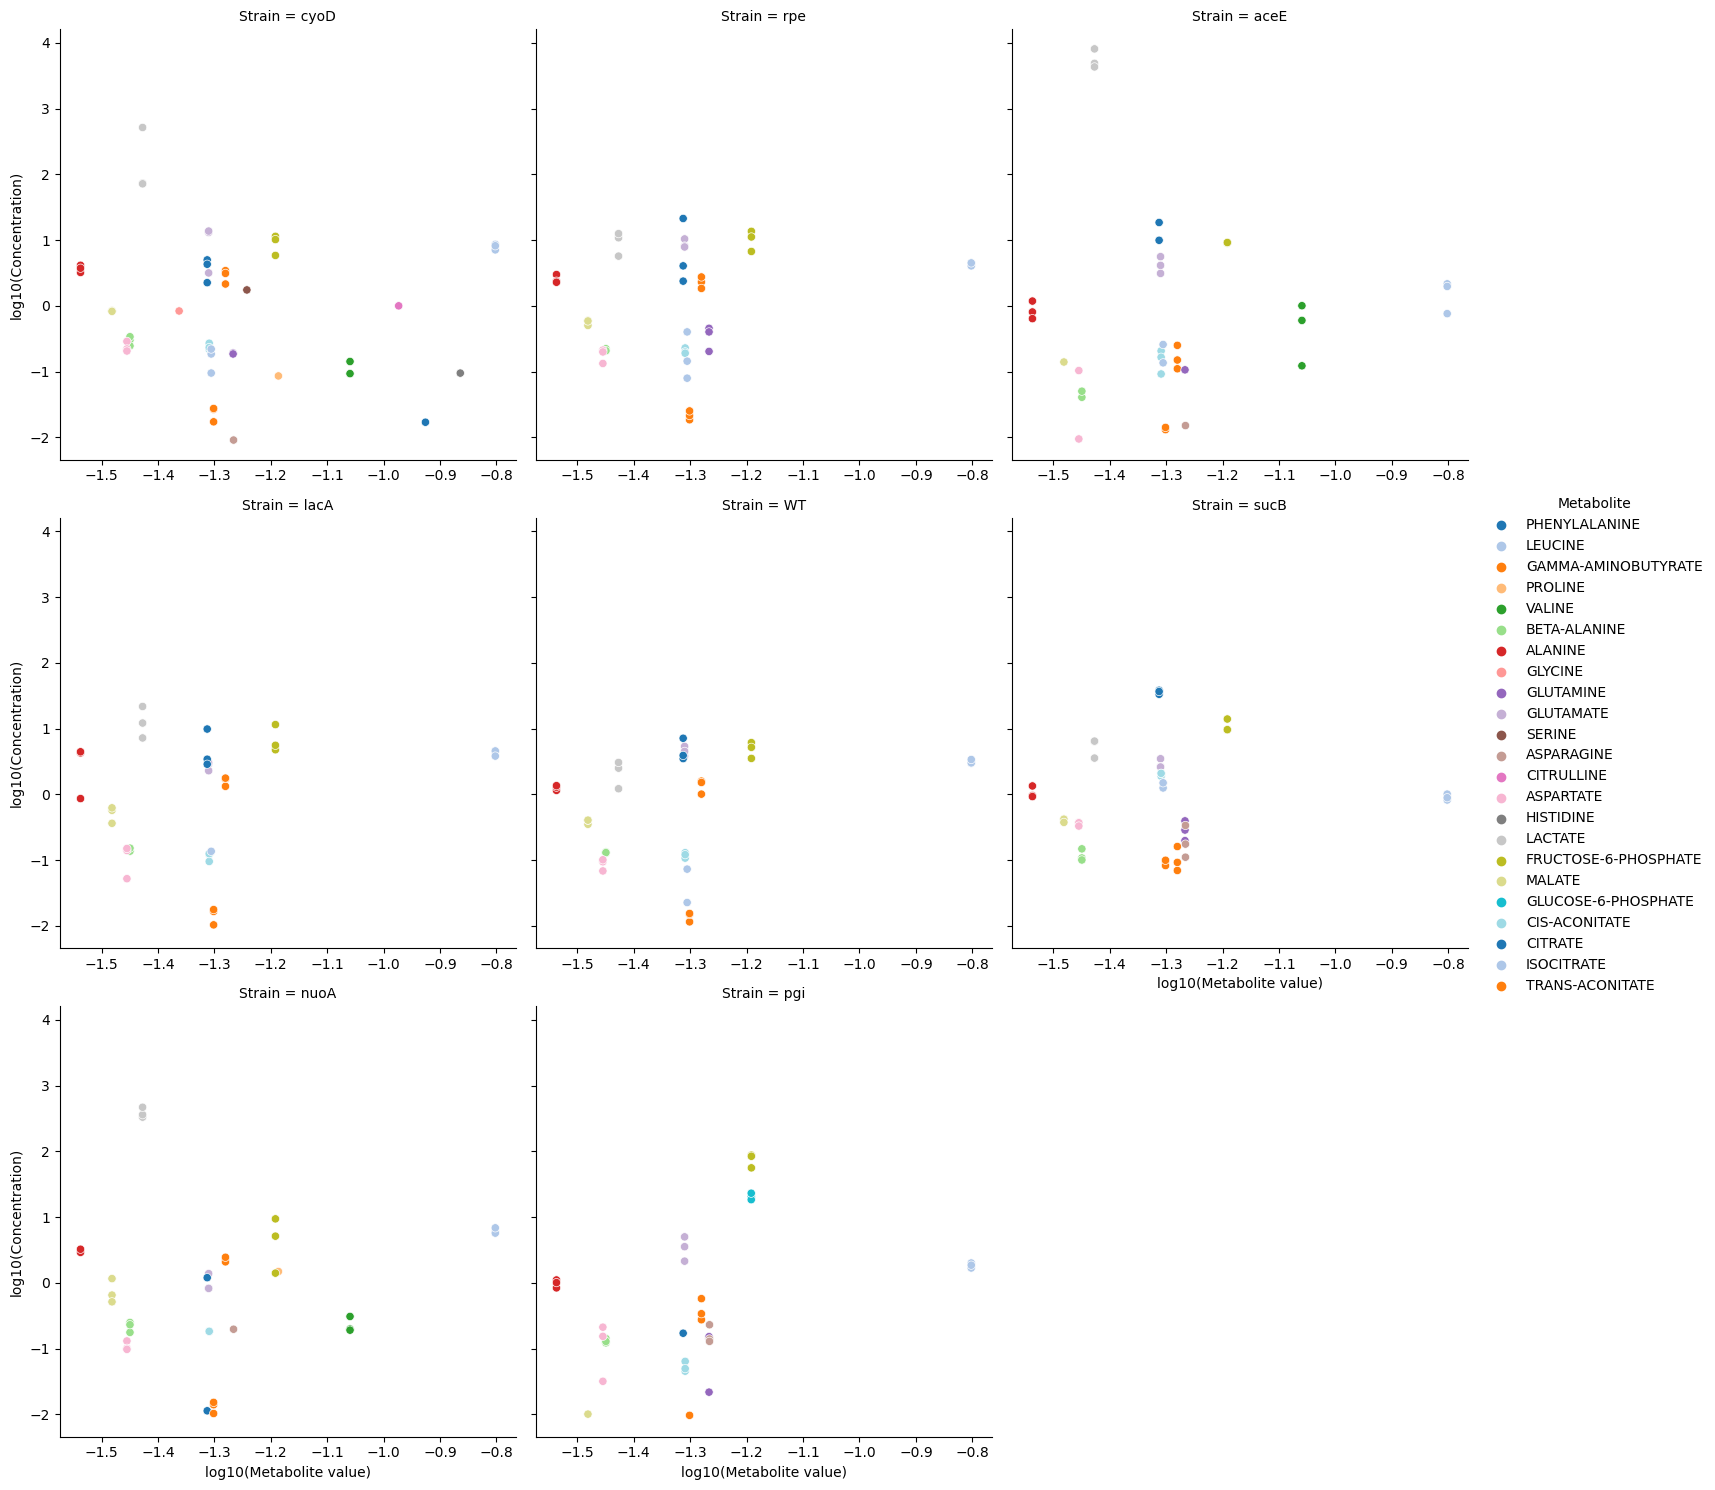

In [364]:
sns.relplot(data = dfl, x = 'log10(Metabolite value)', y = 'log10(Concentration)', col = 'Strain', col_wrap=3, hue = 'Metabolite', palette='tab20', facet_kws={'sharex':False})
plt.show()

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


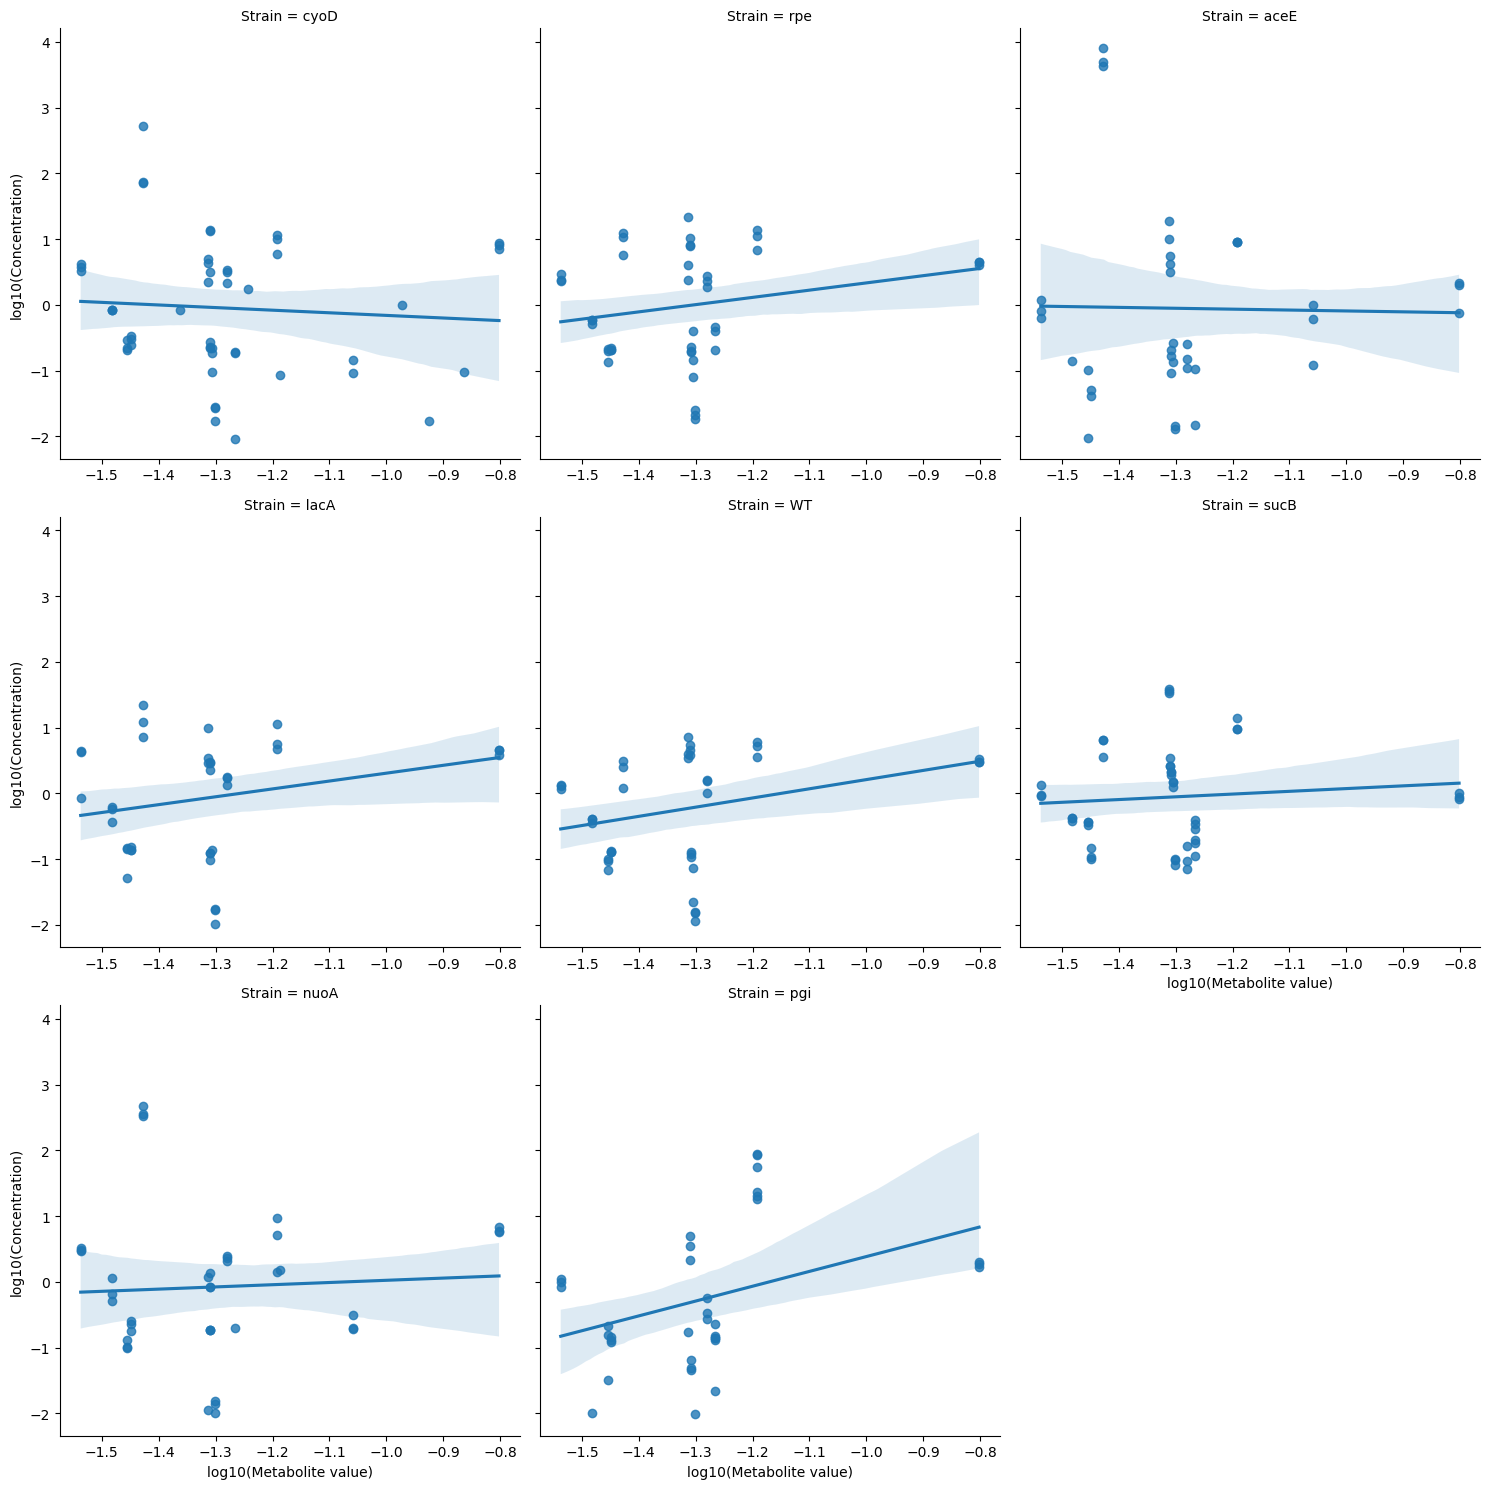

In [365]:
g = sns.lmplot(data = dfl, x = 'log10(Metabolite value)', y = 'log10(Concentration)', col = 'Strain', col_wrap=3, palette='tab20', facet_kws={'sharex':False})
# g.map(sns.regplot, data = dfl, x = 'log10(Metabolite value)', y = 'log10(Concentration)', c)
           # data = df_mean.loc[df_mean.Species=='E. coli'], x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.show()

In [226]:
sp_dict['Galactose']

{'gbbtn_c': nan,
 'crn_c': nan,
 'acon_C_c': -0.0490842494112409,
 'cit_c': -0.0486845731365676,
 'fru_c': -0.06234773273741667,
 'icit_c': -0.04948392568615567,
 'lac__L_c': -0.03739719336751657,
 'mal__L_c': -0.033004391938726285,
 'nad_c': -0.35677048713362025,
 'succ_c': -0.035519952763810037,
 'acon_T_c': -0.04997500088155249,
 'asn__L_c': -0.05421107335717712,
 'asp__L_c': -0.03507890999498997,
 'ala_B_c': -0.03551761963050959,
 '4abut_c': -0.052451122037153186,
 'glu__L_c': -0.04897214592876897,
 'gln__L_c': -0.054108759732043876,
 'gly_c': -0.04341127344432705,
 'ile__L_c': -0.11225894287492655,
 'leu__L_c': -0.15782023224086006,
 'lys__L_c': -0.0933141798649395,
 'met__L_c': -0.22128314764951196,
 'phe__L_c': -0.1186638716297761,
 'pro__L_c': -0.06510936536815726,
 'ser__L_c': -0.05724207447997676,
 'tyr__L_c': -0.1154541991417013,
 'val__L_c': -0.08721324784596585,
 'ala__L_c': -0.029024944803701658,
 'pyr_c': -0.023238980588960456,
 'citr__L_c': -0.1063789283328398,
 'his__L

# Figure out why growth on galactose is so low

In [5]:
model_ez = cobra.io.read_sbml_model('../../models/e_coli/momentiJO1366.xml')
model_ez.id = 'moment-iJO1366'
model_ez.solver = 'gurobi'
model_ez.reactions.EX_glc__D_e.lower_bound = 0
model_ez.reactions.EX_gal_e.lower_bound = -10

In [9]:
solution = model_ez.optimize()

In [21]:
with model_ez as model:
    model.reactions.EX_glc__D_e.lower_bound = -10
    model.reactions.EX_gal_e.lower_bound = 0
    glc_solution = model.optimize()
    print(model.summary())
    
with model_ez as model:
    model.reactions.EX_glc__D_e.lower_bound = 0
    model.reactions.EX_gal_e.lower_bound = -10
    gal_solution = model.optimize()
    print(model.summary())

Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.7044734318697815

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e  0.003667         0   0.00%
      cl_e      EX_cl_e  0.003667         0   0.00%
 cobalt2_e EX_cobalt2_e 1.761E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004995         0   0.00%
     fe2_e     EX_fe2_e   0.01131         0   0.00%
  glc__D_e  EX_glc__D_e        10         6 100.00%
       k_e       EX_k_e    0.1375         0   0.00%
     mg2_e     EX_mg2_e  0.006111         0   0.00%
     mn2_e     EX_mn2_e 0.0004868         0   0.00%
    mobd_e    EX_mobd_e 9.088E-05         0   0.00%
     nh4_e     EX_nh4_e     7.609         0   0.00%
     ni2_e     EX_ni2_e 0.0002275         0   0.00%
      o2_e      EX_o2_e     19.86         0   0.00%
      pi_e      EX_pi_e    0.6796         0   0.00%
     so4_e     EX_so4_e    0.1777         0   0.00%
     zn2_e     EX_zn2_e 0.0002402  

In [22]:
norm_gal_fluxes = gal_solution.fluxes/gal_solution.objective_value
norm_glc_fluxes = glc_solution.fluxes/glc_solution.objective_value

In [45]:
flux_diff = norm_gal_fluxes-norm_glc_fluxes

In [46]:
flux_diff.sort_values(inplace=True)

In [37]:
prot_coeff

-4.06652947852312e-06

In [47]:
prot_coeffs = np.nan*np.zeros(len(flux_diff))
for i, r_id in enumerate(flux_diff.index):
    r = model.reactions.get_by_id(r_id)
    try:
        prot_coeffs[i] = r.metabolites[model.metabolites.prot_pool]
    except KeyError:
        pass
    

In [56]:
flux_diff_df = pd.DataFrame(flux_diff)
flux_diff_df.rename(columns={'fluxes':'Norm flux diff'}, inplace=True)

In [57]:
flux_diff_df['Prot coeffs'] = prot_coeffs

In [59]:
flux_diff_df['Flux gal'] = gal_solution.fluxes

In [64]:
flux_diff_df['Proteome fraction'] = flux_diff_df['Prot coeffs']*np.abs(flux_diff_df['Flux gal'])

In [69]:
flux_diff_df.sort_values('Proteome fraction')

,Norm flux diff,Prot coeffs,Flux gal,Proteome fraction
GALKr_TG_forward,11.264804,-0.016192,2.708386,-0.043855
ATPS4rpp_TG_forward,31.295031,-0.000491,18.591907,-0.009135
NADH16pp,41.560930,-0.000711,9.992456,-0.007107
UDPG4E_TG_reverse,11.264804,-0.001222,2.708386,-0.003311
UGLT_TG_forward,11.264804,-0.001069,2.708386,-0.002896
...,...,...,...,...
GLYt2pp_copy2,0.005205,NaN,0.000000,NaN
EX_o2_e,3.786874,NaN,-5.868039,NaN
ACt2rpp,6.897150,NaN,0.000000,NaN
ATPM,8.630152,NaN,3.150000,NaN


In [92]:
model.metabolites.gal1p_p.reactions

frozenset({<Reaction GAL1PPpp at 0x29b60f050>,
           <Reaction GAL1Ptex_TG_forward at 0x29c09d590>,
           <Reaction GAL1Ptex_TG_reverse at 0x29c075dd0>,
           <Reaction UDPGALPpp at 0x29bc5c710>})

In [93]:
model.reactions.GAL1PPpp

Reaction identifier,GAL1PPpp
Name,D-galactose 1-phosphatase
Memory address,0x29b60f050
Stoichiometry,gal1p_p + h2o_p + 0.000112783622504554 prot_pool --> gal_p + pi_p Alpha-D-Galactose 1-phosphate + H2O H2O + 0.000112783622504554 prot_pool pseudometabolite for unmeasured proteins --> D-Galactose + Phosphate
GPR,b1002
Lower bound,0.0
Upper bound,1000.0


In [91]:
model.reactions.GALKr_TG_forward

Reaction identifier,GALKr_TG_forward
Name,Galactokinase
Memory address,0x29c0badd0
Stoichiometry,atp_c + gal_c + 0.0161922306874758 prot_pool --> adp_c + gal1p_c + h_c ATP C10H12N5O13P3 + D-Galactose + 0.0161922306874758 prot_pool pseudometabolite for unmeasured proteins --> ADP C10H12N5O10P2 + Alpha-D-Galactose 1-phosphate + H+
GPR,b2045 or b0757
Lower bound,0.0
Upper bound,1000.0


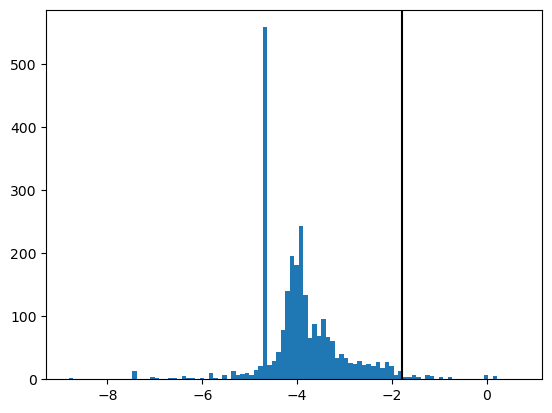

In [82]:
plt.hist(np.log10(-1*flux_diff_df['Prot coeffs']), bins = 100)
plt.axvline(np.log10(0.0161922306874758), c = 'k')